In [5]:
import cv2
import numpy as np
import IPython
import math

def show(img):
    # Save the image to a temporary byte buffer
    is_success, buffer = cv2.imencode(".png", img)
    
    if is_success:
        # Display the image using IPython's display function
        IPython.display.display(IPython.display.Image(data=buffer.tobytes()))
    else:
        print("Error encoding image for display.")

def pixels_to_angle(pixels): # outputs in degrees
    theta =  ( 2 * math.atan(4.25/11) ) * ( pixels / 671.0410824679549 )
    return theta

def pixels_to_distance(pixels):
  theta = pixels * ( 2 * math.atan(4.25/11) ) / ( 671.0410824679549 )
  r_d = 69 # 69 mm
  d_c = r_d / math.sin( theta / 2 )
  return d_c

def extract_ball_position(img1,img2):
    # Calculate the absolute difference
    diff12 = cv2.absdiff(img1, img2)
    
    
    # Dilate the image
    size=15
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    image = cv2.dilate(diff12, kernel_dilate, iterations=1)
    
    # Apply Threshold to the image
    ret, image = cv2.threshold(image, 64, 255, cv2.THRESH_BINARY)
    image = cv2.erode(image, kernel_dilate, iterations=1)
    
    
    # Find contours
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(grey_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Isolate contour with the greatest moment
    greatest_counter, greatest_moment = sorted( 
        [ [ contour, cv2.moments(contour) ] for contour in contours ],
        key=lambda x: x[1]['m00']
    )[-1]
    
    # find center of mass
    pixel_area = greatest_moment['m00']
    alpha_x_pixels = greatest_moment['m10']/pixel_area - 1920/2
    alpha_y_pixels = 1080/2 - greatest_moment['m01']/pixel_area
    alpha_x = pixels_to_angle(alpha_x_pixels)/math.pi*180
    alpha_y = pixels_to_angle(alpha_y_pixels)/math.pi*180
    
    # Find minimum area rectangle, thereby determining the shortest width/theta
    obj = cv2.minAreaRect(greatest_counter)
    print(obj)
    points = cv2.boxPoints(obj)
    points = np.array([[ [[int(point[0]),int(point[1])]] for point in points]])
    
    #calculate ball diameter in pixels
    d_b_pixels = min( obj[1])
    distance = pixels_to_distance(d_b_pixels)/1000

    return {
        "alpha":(alpha_x,alpha_y), # degrees ( right, up )
        'distance':distance # meters
    }

In [9]:
framepaths=[f"G:\\My Drive\\School\\2025 _Spring\\EE 497\\Frame-by-frame demo 01\\0{i}.png" for i in range(1,4) ]

https://stackoverflow.com/questions/56183201/detect-and-visualize-differences-between-two-images-with-opencv-python

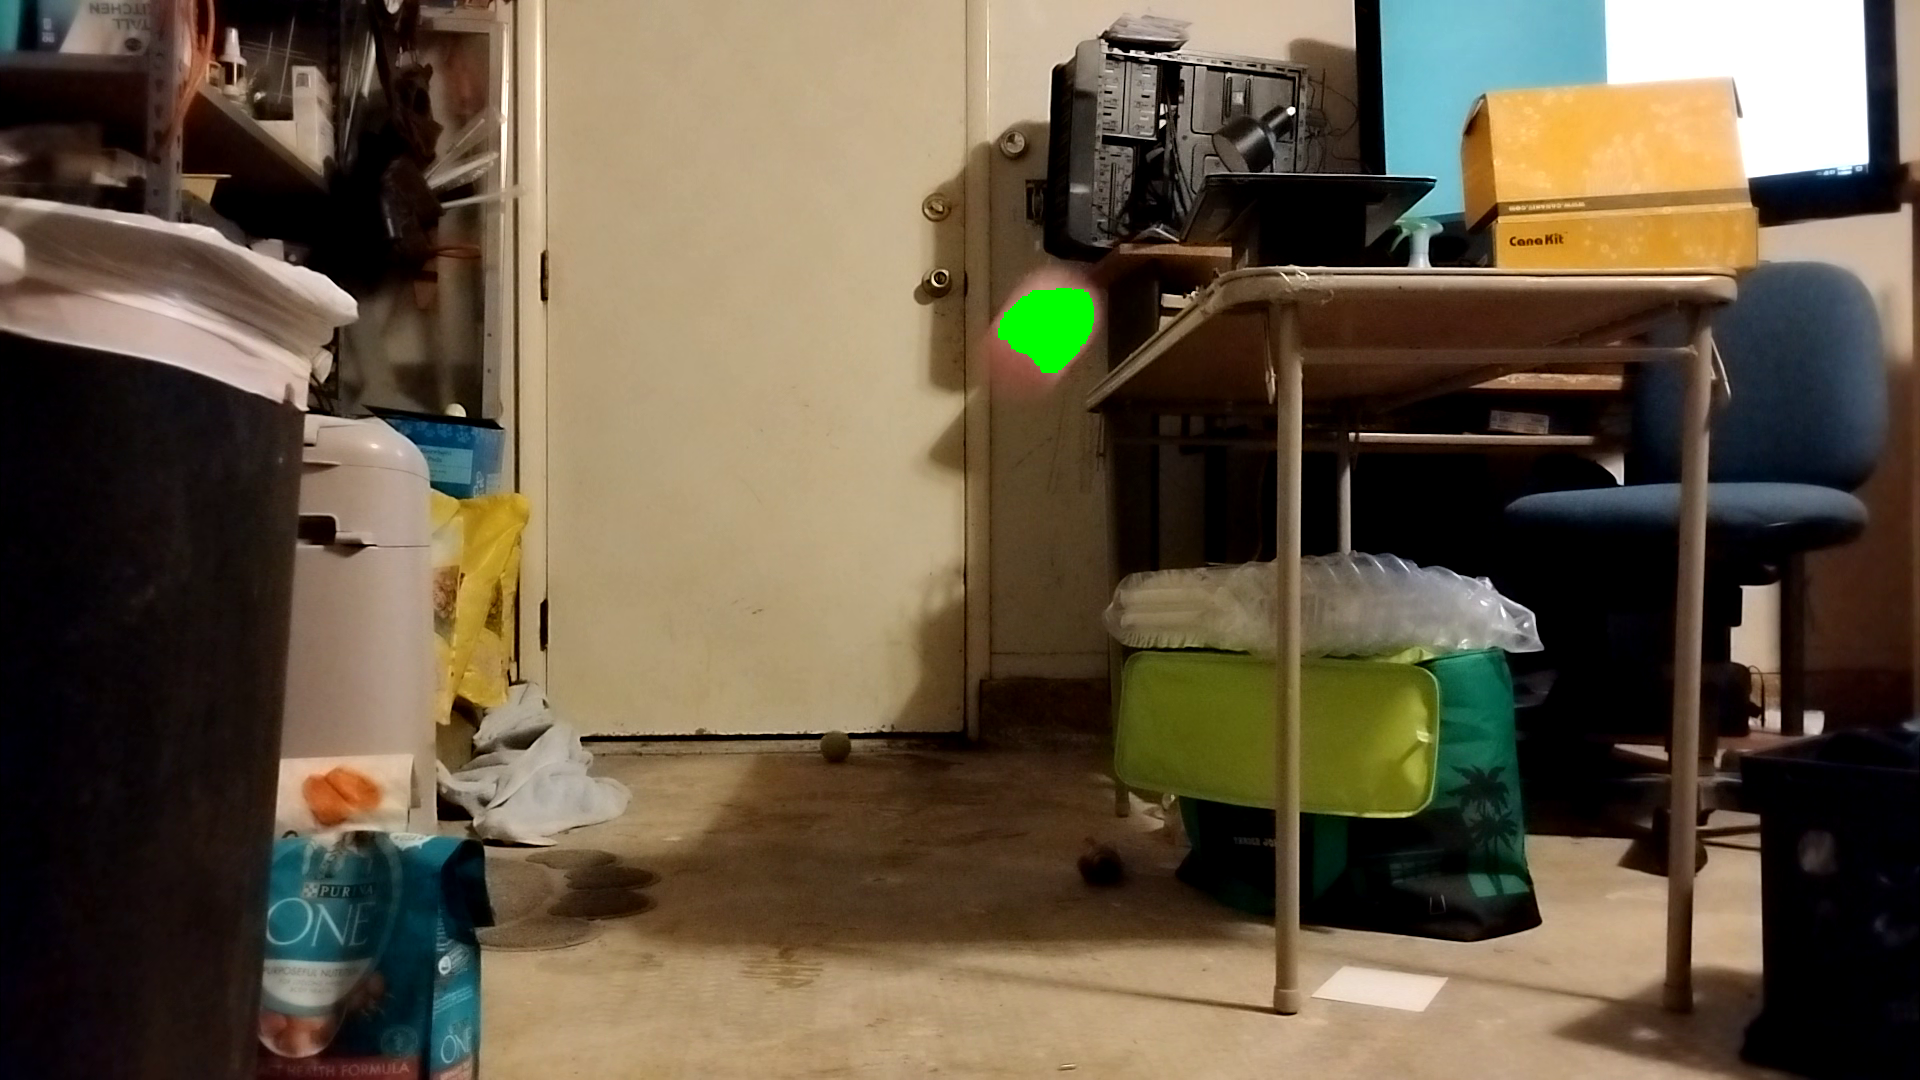

{'alpha': (5.599515654882786, 13.48605396128955), 'distance': 1.5103137718747013}


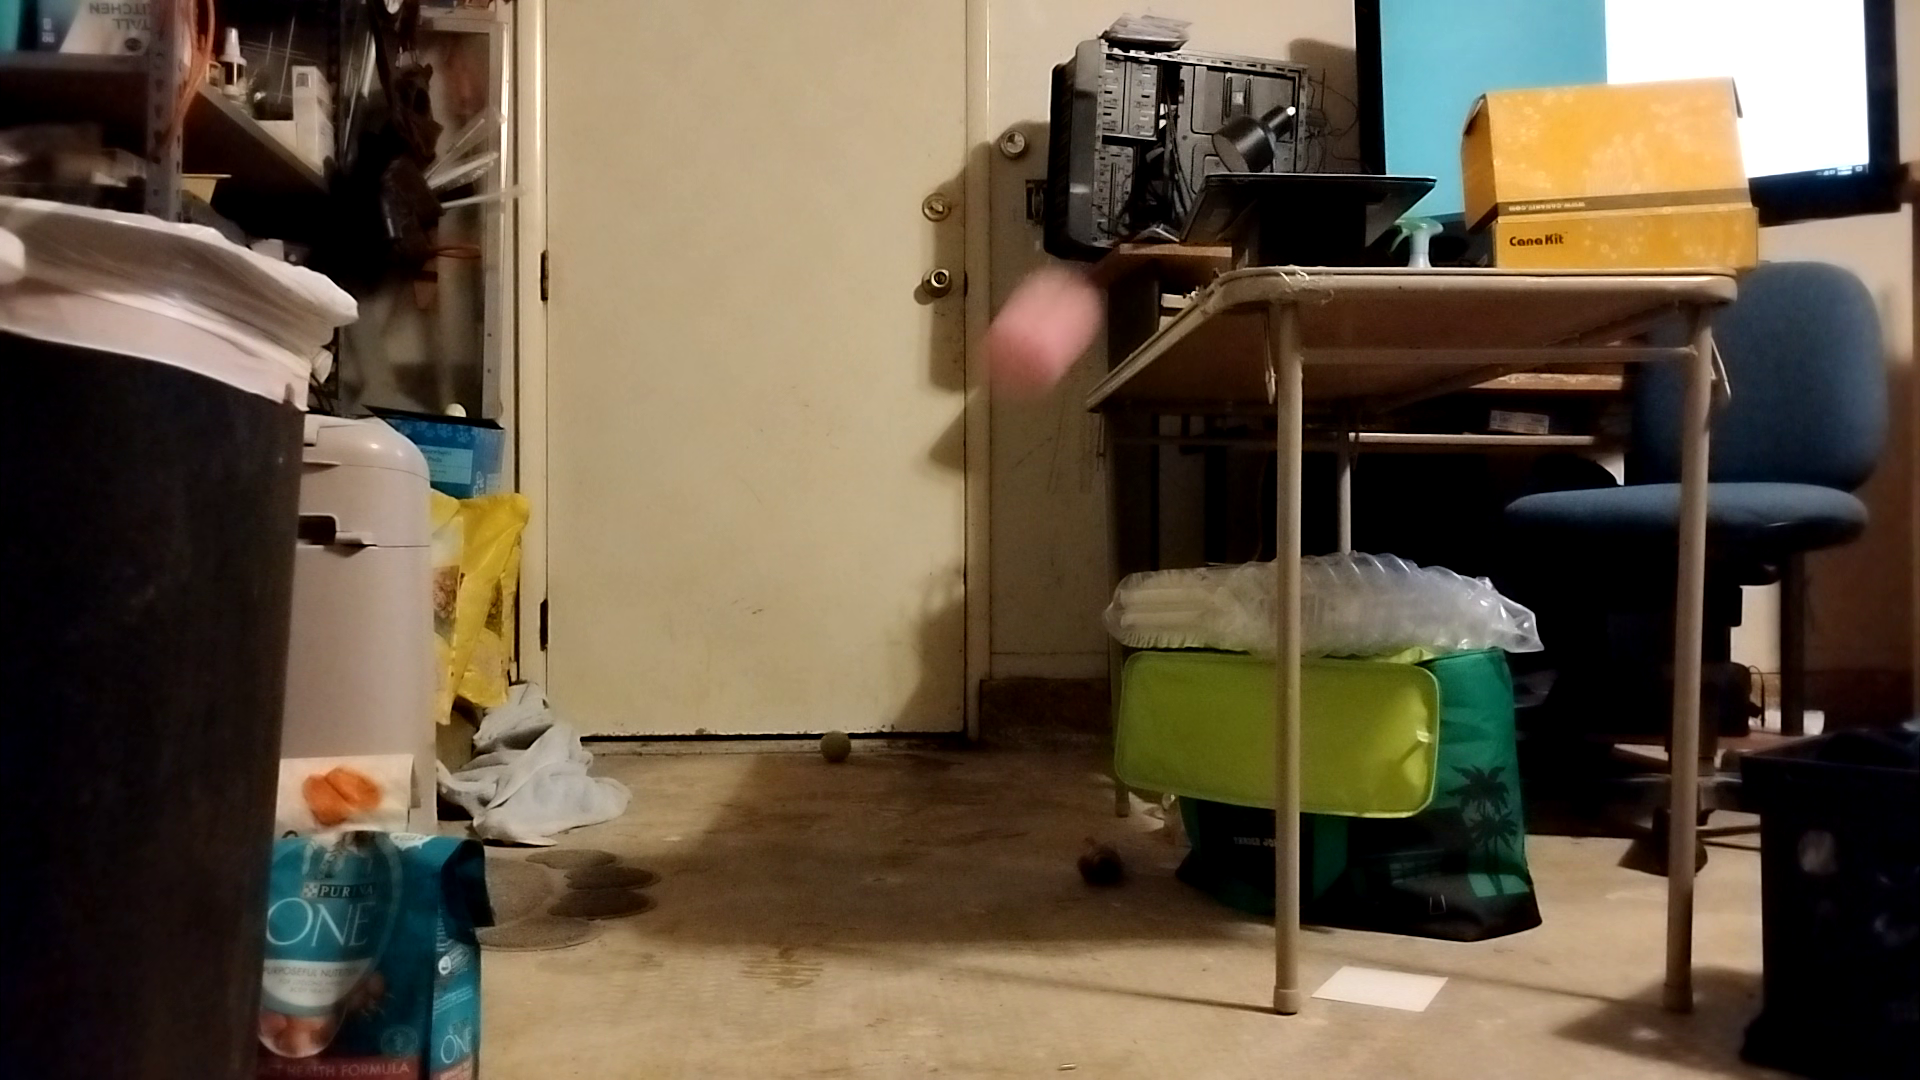

In [11]:
# Load two images for difference calculation
img1 = cv2.imread( framepaths[1] )
img2 = cv2.imread( framepaths[2] )

# Extract ball position
#print(extract_ball_position(img1,img2))
print(extract_pink_ball_position(img1))
show(img1)

In [1]:
def extract_pink_ball_position(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #show(hsv)
    
    lower_green = np.array([int(255*0.0), int(255*0.3), int(255*0.6)])
    upper_green = np.array([int(255*0.03), int(255*0.5), int(255*0.9)])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    #show(mask)
    
    # Dilate the image
    size=5
    iterations = 2
    
    image=mask.copy()
    
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    image = cv2.erode(image, kernel_dilate, iterations=iterations)
    
    image = cv2.dilate(image, kernel_dilate, iterations=iterations)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    
    # Find contours
    # grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Isolate contour with the greatest moment
    greatest_counter, greatest_moment = sorted( 
        [ [ contour, cv2.moments(contour) ] for contour in contours ],
        key=lambda x: x[1]['m00']
    )[-1]
    
    markup = img1.copy()
    markup = cv2.drawContours(markup, [greatest_counter], -1, (0, 255, 0), -1)
    show(markup)
    
    
    # find center of mass
    pixel_area = greatest_moment['m00']
    alpha_x_pixels = greatest_moment['m10']/pixel_area - 1920/2
    alpha_y_pixels = 1080/2 - greatest_moment['m01']/pixel_area
    alpha_x = pixels_to_angle(alpha_x_pixels)/math.pi*180
    alpha_y = pixels_to_angle(alpha_y_pixels)/math.pi*180
    
    # Find minimum area rectangle, thereby determining the shortest width/theta
    obj = cv2.minAreaRect(greatest_counter)
    
    # markup = img.copy()
    # markup = cv2.drawContours(markup,points,-1,(255,00,255),10)
    # show(markup)
    
    points = cv2.boxPoints(obj)
    points = np.array([[ [[int(point[0]),int(point[1])]] for point in points]])
    
    #calculate ball diameter in pixels
    d_b_pixels = min( obj[1])
    distance = pixels_to_distance(d_b_pixels)/1000
    
    return {
        "alpha":(alpha_x,alpha_y), # degrees ( right, up )
        'distance':distance # meters
    }